In [1]:
  %%capture
!pip install torcheval-nightly

In [2]:
# Importamos las librerías necesarias para la ejecución del código

import torch
from torch import nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import ToTensor
from torcheval.metrics.functional import multiclass_accuracy # Para un batch
from torcheval.metrics import MulticlassAccuracy # Puede acumular sobre batches
from torcheval.metrics.functional import multiclass_confusion_matrix # Para un batch
from torcheval.metrics import MulticlassConfusionMatrix # Puede acumular sobre batches
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Carga del dataset

### El Dataset utilizado fue extraído del repositori de Kaggle llamado **Banana Leaf Spot Diseases (BananaLSD) Dataset**, elaborado por *Shifat E Arman*.
[https://www.kaggle.com/datasets/shifatearman/bananalsd](https://www.kaggle.com/datasets/shifatearman/bananalsd)

In [4]:
# Conectamos el notebook al Drive donde se encuentra alojado el Dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/Shareddrives/RNYABI/Trabajo3/dataset/AugmentedSet/'

## Conteo de los datos

In [ ]:
# Contar archivos y carpetas en la ruta especificada

def count_files_and_folders(directory):
    file_count = 0
    folder_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)
        folder_count += len(dirs)
    return file_count, folder_count

# Obtener la cantidad de archivos y carpetas
files, folders = count_files_and_folders(path)

print(f'Número de archivos: {files}')
print(f'Número de carpetas: {folders}')

Número de archivos: 1600
Número de carpetas: 4


In [ ]:
# Verifica las carpetas que contiene el dataset. Los nombres de las carpetas
# corresponden a las clases del problema

directories = os.listdir(path)
directories = [item for item in directories if item != "processedDataset"]
directories

['pestalotiopsis', 'sigatoka', 'cordana', 'healthy']

## Verificacion de tamaños
Tomamos 5 imagenes por cada carpeta y verificamos sus tamaños

In [ ]:
sizesList = []
for directory in directories:
  # print(directory)
  subList = []
  for i,img in enumerate(os.listdir(path + directory)):
    # print(i)
    # print(img)
    if i == 5:
      break
    imagen = cv2.imread(path + directory + "/" + img)
    subList.append(imagen.shape)
  sizesList.append(subList)


In [ ]:
sizesList

[[(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)],
 [(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)],
 [(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)],
 [(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)]]

## Preprocesamiento

### Encontrando los valores de normalización

In [7]:
# Define las transformaciones para preprocesar las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),          # Convertir las imágenes a tensores
])


dataset = datasets.ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
# Cálculo de la media y la desviación estándar
mean = 0.0
std = 0.0
for images, _ in dataloader:
    batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(dataset)
std /= len(dataset)

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.5001, 0.5484, 0.3073])
Std: tensor([0.1166, 0.1007, 0.1147])

### Normalizando datos

In [ ]:
# Se normalizan los datos ya convertidos a tensores

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = datasets.ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

### Separando el dataset

In [10]:
# Divide el dataset en entrenamiento y validación
num_samples = len(dataset)

# Definir longitudes para cada conjunto, donde se tendrá un 80% para el
# entrenamiento y un 10% para la validación
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size = num_samples - train_size - val_size

# Dividir dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [11]:
# Crear DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
# Se verifica el contenido de los Dataloaders

for x,y in train_dataloader:
  print(f"shape of x [N, C, H, W]: {x.shape}")
  print(f"shape of y: {y.shape} {y.dtype}")
  break

  #N: dimn del lote
  #C: colores de la imagen
  #H: height of image
  #W: width  of image

shape of x [N, C, H, W]: torch.Size([64, 3, 224, 224])
shape of y: torch.Size([64]) torch.int64


Cada batch contiene 64 imagenes de 3 canales, con un tamaño de (224,224)

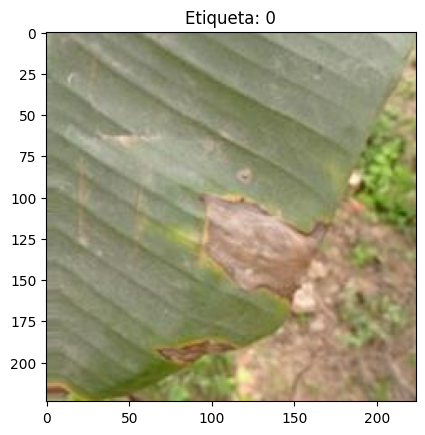

In [26]:
i = 7 # Controla el elemento del conjunto de datos que se grafica.
plt.imshow(test_dataloader.dataset.dataset[i][0].permute(1, 2, 0))    # Cambia de (C, H, W) a (H, W, C) ya qu es en 3 dimensiones
plt.title('Etiqueta: ' + str(test_dataloader.dataset.dataset[i][1]))
plt.show()

In [27]:
# Se elige entre CPU, GPU y MPS para el entrenamiento
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
# Función para entrenar una red de clasificación lineal

class RedLinealClasificacion(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()  # Aplana la imagen de entrada
        self.componente_lineal = nn.Sequential(
            nn.Linear(3 * 224 * 224, 512),  # Capa lineal ajustada para imágenes RGB de 224x224
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 4)  # Número de clases para la clasificación
        )

    def forward(self, x):
        x = self.flatten(x)  # Aplana la entrada
        logits = self.componente_lineal(x)  # Pasa a través de las capas lineales
        return logits


In [ ]:
torch.random.manual_seed(1984) # Esta aleatorización depende de Torch
model = RedLinealClasificacion().to(device)
with torch.no_grad():
    print(model)

RedLinealClasificacion(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (componente_lineal): Sequential(
    (0): Linear(in_features=150528, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [ ]:
# Función para entrenar una red neuronal convolucional

class CNNClasificacion(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Aplanar la salida para las capas lineales
        x = nn.ReLU()(self.fc1(x))
        logits = self.fc2(x)
        return logits


In [ ]:
torch.random.manual_seed(1984) # Esta aleatorización depende de Torch
model = CNNClasificacion().to(device)
with torch.no_grad():
    print(model)

CNNClasificacion(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


In [35]:
# Función para entrenar una red neuronal convolucional basada en el modelo ResNet

class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        # Cargar el modelo ResNet preentrenado
        self.resnet = models.resnet50(pretrained=True)

        # Reemplazar la capa final de clasificación de ResNet para adaptarse al número de clases deseado
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remover la capa final existente

        # Definir las nuevas capas de clasificación
        self.fc1 = nn.Linear(in_features, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.resnet(x)  # Pasar por el ResNet sin la capa final
        x = self.fc1(x)    # Pasar por la capa densa 1
        x = self.relu(x)   # Aplicar ReLU
        x = self.fc2(x)    # Pasar por la capa densa 2
        x = self.softmax(x)  # Aplicar Softmax
        return x


In [36]:
torch.random.manual_seed(1984) # Esta aleatorización depende de Torch
model = ResNetModel().to(device)
with torch.no_grad():
    print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.3MB/s]


ResNetModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [37]:
# dir(train_dataloader.dataset.data)
X, y = next(iter(test_dataloader))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 3, 224, 224]) torch.float32 torch.Size([64]) torch.int64


## Entrenamiento del modelo

In [38]:
# Definir la función de pérdida
loss_fn = nn.CrossEntropyLoss()

# Definir el optimizador
optimizer = torch.optim.RAdam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [39]:
train_loss = []
train_acc = []

val_loss = []
val_acc = []

# Se define una función general para realizar el entrenamiento del modelo seleccionado

def train(dataloader, model, loss_fn, optimizer):
    epoch_train_loss = 0.0
    epoch_train_correct = 0
    total_train_samples = 0

    size = len(dataloader.dataset)
    model.train()



    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        logits = model(X)
        loss = loss_fn(logits, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular la pérdida y precisión
        epoch_train_loss += loss.item() * X.size(0)
        _, predicted = torch.max(logits, 1)
        epoch_train_correct += (predicted == y).sum().item()
        total_train_samples += y.size(0)


        if batch % 100 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss.append(epoch_train_loss / total_train_samples)
    train_acc.append(epoch_train_correct / total_train_samples)



In [40]:
# Se define una función test para evaluar el modelo entrenado dentro del conjunto de testeo

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    metric_multiacc = MulticlassAccuracy(average = None,  num_classes = 4)
    metric_matconf = MulticlassConfusionMatrix(num_classes = 4)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            metric_multiacc.update(pred, y)
            metric_matconf.update(pred, y)
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Multi accuracy: \n {metric_multiacc.compute()}")
    print(f"Matriz de confusión: \n {metric_matconf.compute()}")
    metric_multiacc.reset()
    metric_matconf.reset()

## Entrenamiento

In [42]:
# Se realiza el entrenamiento del modelo seleccionado, en este caso con 10 épocas

epochs = 10  # Número de épocas

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.386647  [   64/ 1280]
Test Error: 
 Accuracy: 89.4%, Avg loss: 1.068318 

Multi accuracy: 
 tensor([0.9474, 1.0000, 0.6250, 1.0000])
Matriz de confusión: 
 tensor([[36.,  2.,  0.,  0.],
        [ 0., 37.,  0.,  0.],
        [ 0., 14., 25.,  1.],
        [ 0.,  0.,  0., 45.]])
Epoch 2
-------------------------------
loss: 1.032468  [   64/ 1280]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.764379 

Multi accuracy: 
 tensor([1.0000, 1.0000, 1.0000, 0.9778])
Matriz de confusión: 
 tensor([[38.,  0.,  0.,  0.],
        [ 0., 37.,  0.,  0.],
        [ 0.,  0., 40.,  0.],
        [ 0.,  0.,  1., 44.]])
Epoch 3
-------------------------------
loss: 0.761828  [   64/ 1280]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.750552 

Multi accuracy: 
 tensor([1., 1., 1., 1.])
Matriz de confusión: 
 tensor([[38.,  0.,  0.,  0.],
        [ 0., 37.,  0.,  0.],
        [ 0.,  0., 40.,  0.],
        [ 0.,  0.,  0., 45.]])
Epoch 4
-------------------------------


In [43]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 98.8%, Avg loss: 0.759349 

Multi accuracy: 
 tensor([1.0000, 1.0000, 1.0000, 0.9556])
Matriz de confusión: 
 tensor([[38.,  0.,  0.,  0.],
        [ 0., 37.,  0.,  0.],
        [ 0.,  0., 40.,  0.],
        [ 1.,  0.,  1., 43.]])


### Guardar Modelo

In [44]:
# Se guarda el modelo entrenado en el Drive para su posterior implementación

PATH = '/content/drive/Shareddrives/RNYABI/Trabajo3/checkpoint2.pt'
torch.save(model.state_dict(), PATH)

### Evaluación

In [45]:
# Se define una función para realizar la evaluación del modelo, posterior a su entrenamiento

def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Poner el modelo en modo de evaluación
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            test_loss += loss_fn(logits, y).item()
            pred = logits.argmax(dim=1)  # Obtener las predicciones
            correct += (pred == y).sum().item()

    test_loss /= num_batches
    accuracy = correct / size
    print(f"Validation Error: \n Avg loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")


In [46]:
# Evaluar el modelo usando el DataLoader de validación
evaluate(val_dataloader, model, loss_fn)


Validation Error: 
 Avg loss: 0.7583, Accuracy: 0.9875


In [47]:
model.eval()  # Poner el modelo en modo evaluación
predicciones = []  # Lista para almacenar las predicciones

with torch.no_grad():  # No se necesita calcular gradientes durante la evaluación
    for inputs, _ in test_dataloader:
        inputs = inputs.to(device)  # Mover los inputs a la GPU
        outputs = model(inputs)  # Obtener las predicciones del modelo
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad
        predicciones.extend(predicted.cpu().numpy())  # Mover las predicciones a CPU y almacenarlas


In [48]:
print(predicciones)

[3, 2, 2, 2, 0, 2, 0, 1, 2, 1, 0, 1, 2, 2, 3, 1, 3, 3, 1, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 1, 3, 3, 2, 2, 2, 2, 0, 1, 0, 3, 1, 0, 1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 1, 1, 3, 2, 3, 0, 1, 3, 0, 3, 1, 1, 2, 3, 1, 1, 2, 3, 1, 3, 2, 2, 2, 3, 0, 3, 0, 1, 1, 2, 1, 3, 3, 1, 0, 0, 2, 3, 1, 0, 3, 0, 0, 3, 1, 3, 3, 2, 2, 2, 2, 3, 3, 1, 3, 3, 3, 1, 2, 0, 1, 0, 0, 0, 3, 1, 3, 3, 0, 3, 1, 3, 2, 3, 2, 2, 0, 2, 3, 2, 3, 1, 1, 1, 2, 1, 1, 3, 2, 0, 2, 1, 3, 2, 1, 3, 0, 1, 0, 3, 3, 0, 3, 2, 0]


##Prueba del modelo

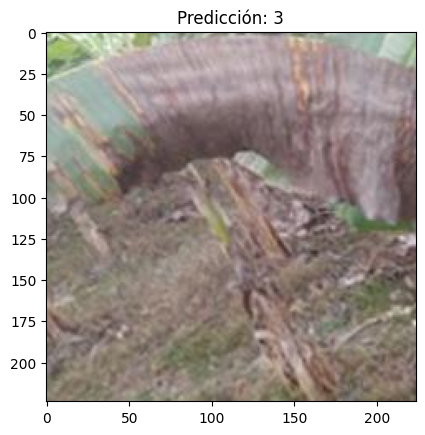

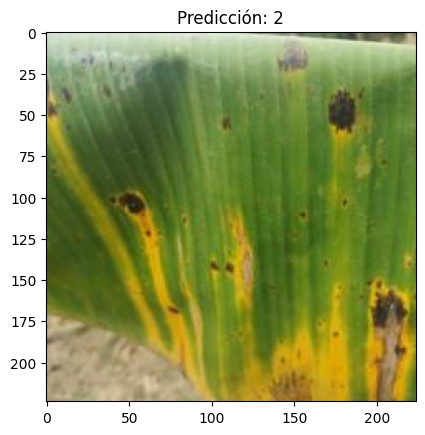

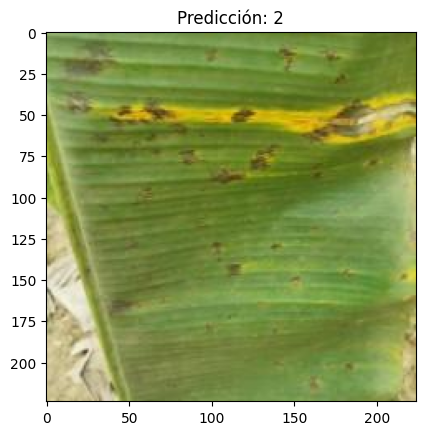

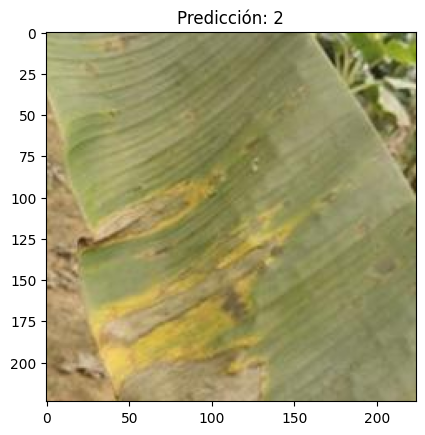

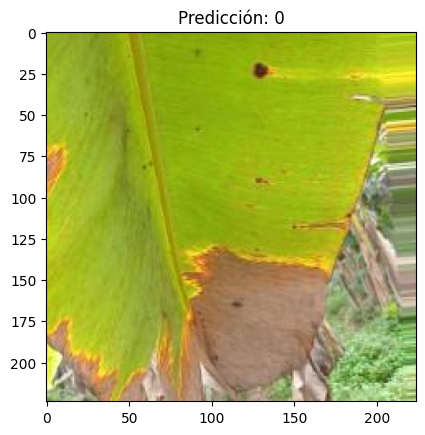

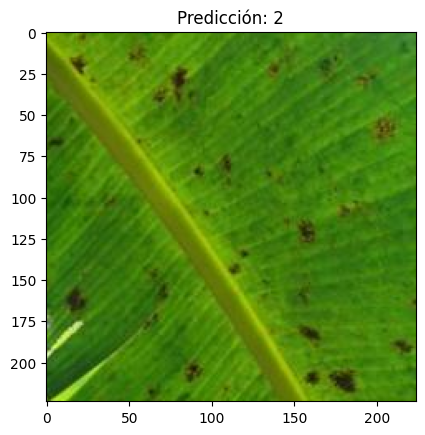

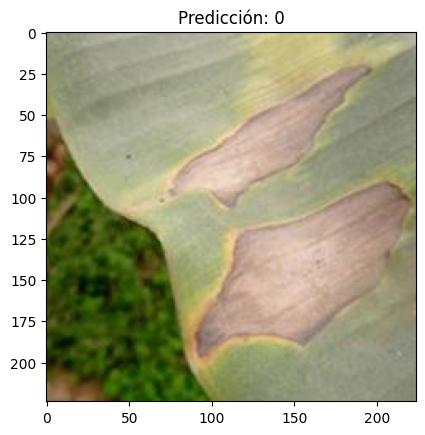

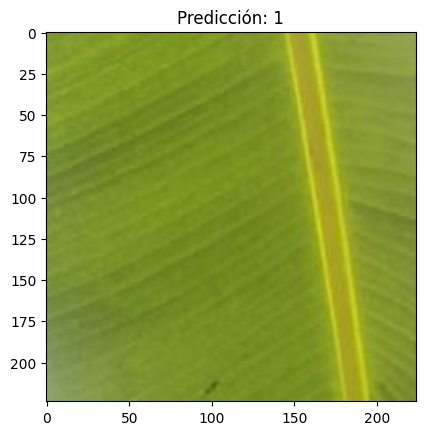

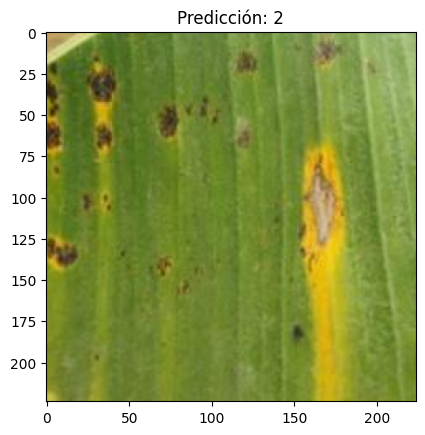

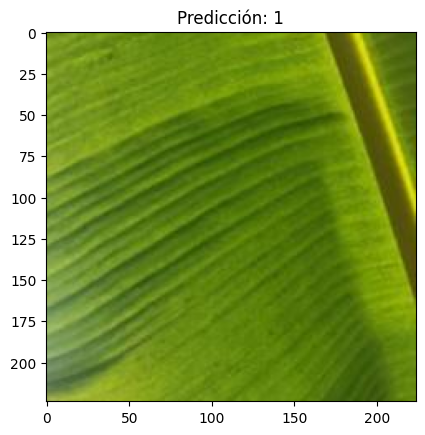

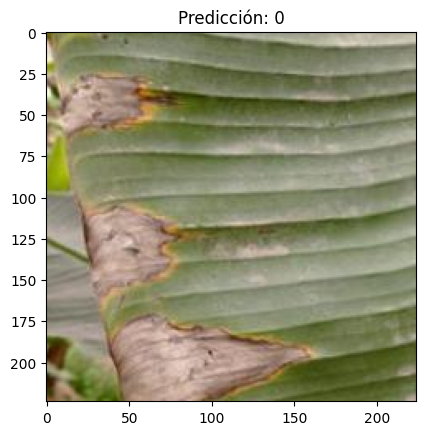

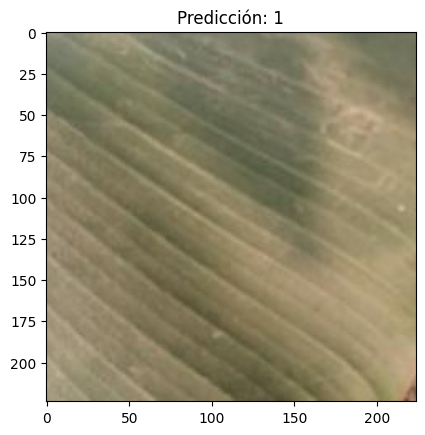

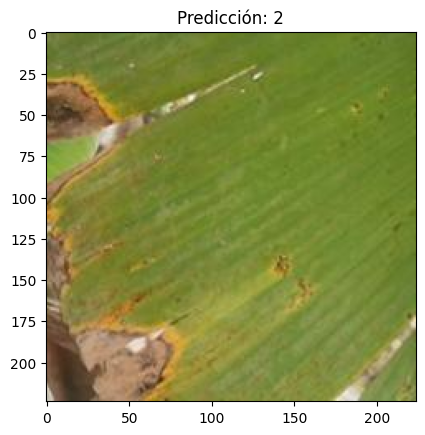

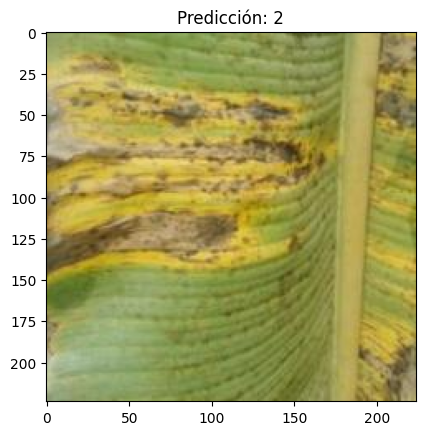

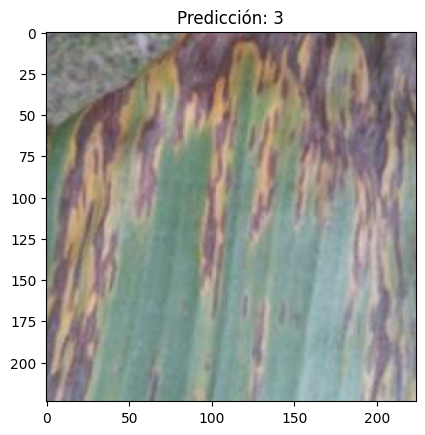

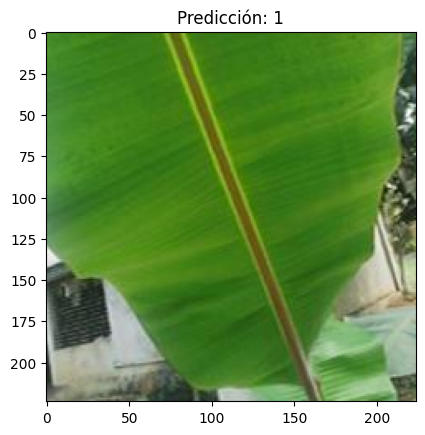

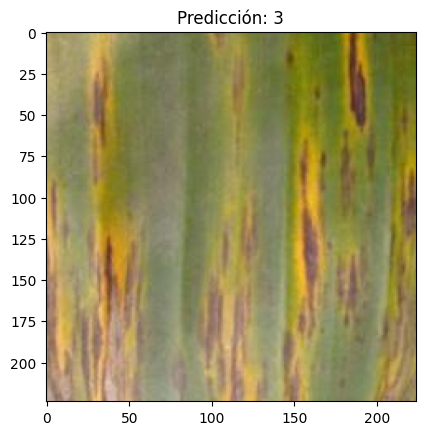

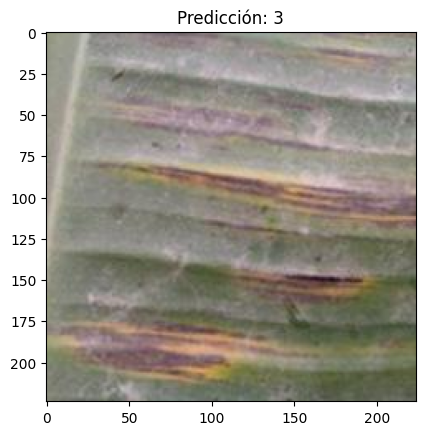

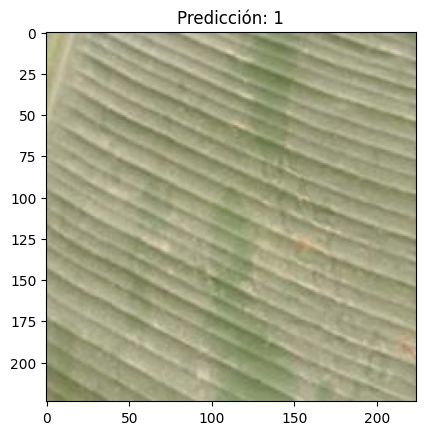

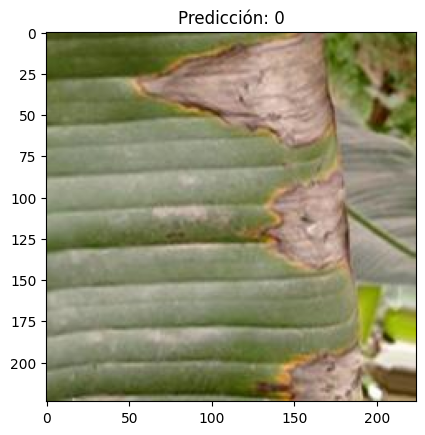

In [49]:
# Ejemplo: Mostrar las primeras 5 imágenes con sus predicciones
for i in range(20):
    image, label = test_dataloader.dataset[i]
    plt.imshow(image.permute(1, 2, 0))  # Cambiar el orden de los canales para que sea compatible con matplotlib
    plt.title(f"Predicción: {predicciones[i]}")
    plt.show()

In [50]:
import pandas as pd

# Suponiendo que también tienes las etiquetas verdaderas para comparación
etiquetas_verdaderas = [label for _, label in test_dataloader.dataset]

df = pd.DataFrame({
    'Etiqueta Verdadera': etiquetas_verdaderas,
    'Predicción': predicciones
})

# Mostrar las primeras filas del DataFrame
df

Etiqueta Verdadera  Predicción
0                     3           3
1                     2           2
2                     2           2
3                     2           2
4                     0           0
..                  ...         ...
155                   3           3
156                   0           0
157                   3           3
158                   2           2
159                   0           0

[160 rows x 2 columns]

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

Precisión: 0.99


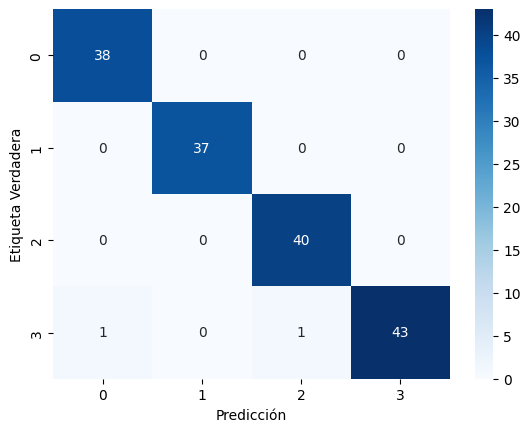

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      1.00      1.00        37
           2       0.98      1.00      0.99        40
           3       1.00      0.96      0.98        45

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



In [53]:
# Calcular precisión
precision = accuracy_score(etiquetas_verdaderas, predicciones)
print(f'Precisión: {precision:.2f}')

# Matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_verdaderas, predicciones)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# Reporte de clasificación
print(classification_report(etiquetas_verdaderas, predicciones))

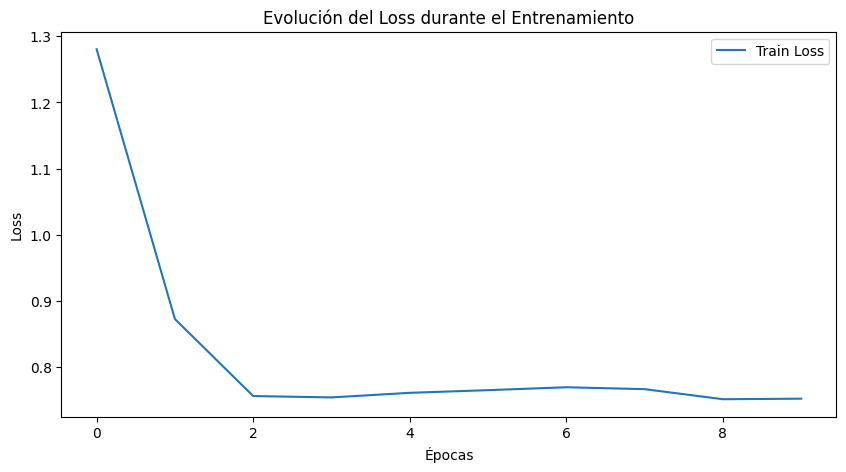

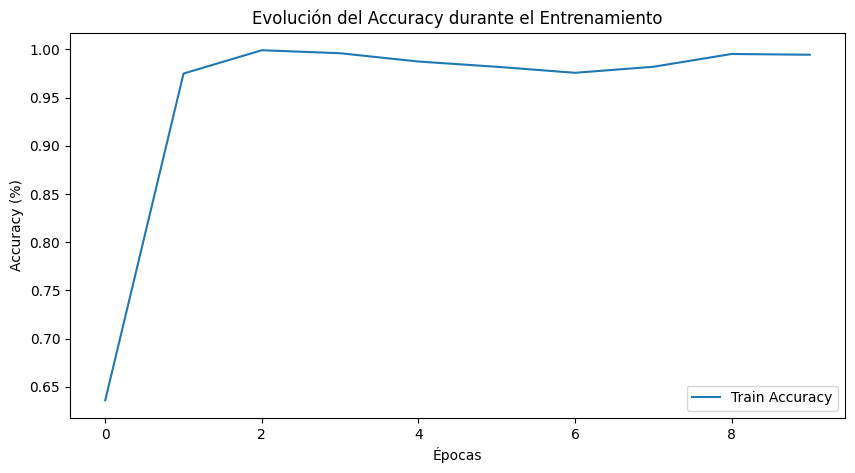

In [54]:
plt.close('all')

# Gráfica de la pérdida
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss')
plt.title('Evolución del Loss durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfica de la exactitud
plt.figure(figsize=(10,5))
plt.plot(train_acc, label='Train Accuracy')
plt.title('Evolución del Accuracy durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


# Preprocesamiento Nueva Entrada

In [55]:
def resize_image(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    shape = image.shape

    if shape == (224, 224, 3):
      return image
    else:
      dim = (224, 224)
      resized = cv2.resize(image, dim)
      return resized

## Preprocesamiento de las entradas

tensor([1], device='cuda:0')
Tiempo de ejecución incluyendo carga del modelo: 1.9930212497711182 segundos
Tiempo de ejecución evaluación y predicción: 0.14340519905090332 segundos


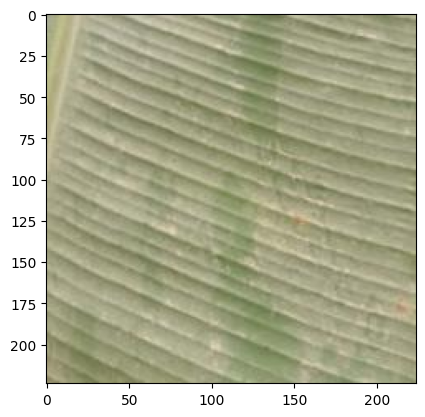

In [87]:
start_time_all = time.time()
PATH = '/content/drive/Shareddrives/RNYABI/Trabajo3/checkpoint2.pt'
model1 = ResNetModel().to(device)
model1.load_state_dict(torch.load(PATH))
#model1.eval()

start_time_eval = time.time()
path = '/content/drive/Shareddrives/RNYABI/Trabajo3/dataset/AugmentedSet/healthy/245_aug.jpeg'

im = cv2.imread(path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.imshow(im)

result = resize_image(path)

# print(result.shape)
# print(type(result))

preprocess = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

img = Image.open(path)
img_tensor = preprocess(result)
img_tensor = img_tensor.unsqueeze(0) # Add a batch dimension
img_tensor = img_tensor.to(device)

#  img_tensor.shape

with torch.no_grad():  # No need to compute gradients
    model1.eval()
    output = model1(img_tensor)

# The output will be raw scores (logits); apply softmax to get probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the predicted class index
_, predicted_class = torch.max(output, 1)

# plt.imshow(result)
print(predicted_class)

end_time = time.time()

execution_time_all = end_time - start_time_all
execution_time_eval = end_time - start_time_eval
print(f"Tiempo de ejecución incluyendo carga del modelo: {execution_time_all} segundos")
print(f"Tiempo de ejecución evaluación y predicción: {execution_time_eval} segundos")